# Supplementary material

In this notebook, we provide the code for training and evaluating the models from out CIFAR10 experiment. How we arrived at these models can be found in supplementary notebook *DecoderTraining_CIFAR10_modelSearch.ipynb*

In [2]:
# insert your own directory to a designated folder on drive

direc = '/content/drive/MyDrive/Work/DGML/'

# Imports and Functions

In [3]:
import sys
import os
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import torchvision
from torchvision import transforms
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Functions

### Data-related

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

class CIFAR10_Dataset(torch.utils.data.Dataset):
    '''
    Commonly used class to get CIFAR10 dataset.
    Although one could now also just use the pytorch implementation
    torchvision.datasets.CIFAR10()
    '''
    def __init__(self, nsample=1000, train=True):
      super(CIFAR10_Dataset, self).__init__()
      self.data = torchvision.datasets.CIFAR10(root='./data', train=train,
                                          download=True, transform=transform)
      self.nsample = len(self.data)

    def __getitem__(self, index):
      data, target = self.data[index]
      return data, target, index

    def __len__(self):
      return self.nsample

# CIFAR10 classes in order of integers
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def find_matching_index(idx, a):
    '''
    This function is used in training when using a subset of the data.
    It allows us to match the representation id to the subset id
    (which is still the original data id).
    '''
    return [np.where(idx == x)[0][0] for x in a]

def balanced_subset_list(t_set, step):
    '''
    We want CIFAR10 subsets not to be randomly sampled but balanced in terms of
    images per class. This function gets each classes' image ids and samples
    every STEP's image id.
    '''
    labels = [classes[x[1]] for x in t_set.data]
    unique_classes = list(set(labels))
    id_position_out = np.zeros(len(labels))
    for lbl in unique_classes:
        ids = [x for x in range(len(labels)) if labels[x] == lbl]
        keep = [ids[x] for x in range(len(ids)) if x % step == 0]
        id_position_out[keep] = 1
    out = list(np.where(id_position_out == 1)[0])
    return out

### Model classes

In [5]:
class DecoderModule(nn.Module):
    '''
    Decoder module starting from a channel x 1 x 1 tensor.
    Channel steps are defined by a defined basis called capacity
    which is doubled every second layer (output to input).
    Decoders are build with ConvTranspose layers.
    '''
    def __init__(self,c):
        super(DecoderModule, self).__init__()
        self.capacity = c

        self.cnn = nn.Sequential(
          nn.ConvTranspose2d(in_channels=c*4, out_channels=c*2, kernel_size=4, stride=2, padding=0),
          nn.BatchNorm2d(c*2),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(in_channels=c*2, out_channels=c*2, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(c*2),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(c),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(in_channels=c, out_channels=c, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(c),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=1, stride=1, padding=0),
          nn.Sigmoid()
          )
        
    def forward(self, x):
        x = self.cnn(x)
        return x

class Decoder(nn.Module):
    '''
    Decoder takes decoder model and only adds a step in which to make sure
    to have the input in the right format. This is needed when using the decoder
    only to reshape the 1D representation vector into a 3D tensor.
    '''
    def __init__(self,c):
        super(Decoder, self).__init__()
        self.capacity = c

        self.dec = DecoderModule(c=c)
        
    def forward(self, x):
        x = x.view(x.size(0), self.capacity*4, 1, 1) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = self.dec(x)
        return x

class EncoderModule(nn.Module):
    '''
    Inverse of DecoderModule. Using Conv layers here.
    '''
    def __init__(self,c):
        super(EncoderModule, self).__init__()
        self.capacity = c
        self.cnn = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=c, kernel_size=1, stride=1, padding=0),
          nn.BatchNorm2d(c),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=c, out_channels=c, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(c),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(c*2),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=c*2, out_channels=c*2, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(c*2),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=c*2, out_channels=c*4, kernel_size=4, stride=2, padding=0),
          nn.ReLU(True))
            
    def forward(self, x):
        x = self.cnn(x)
        return x

class AE(nn.Module):
    '''Autoencoder built from encoder module and decoder module'''
    def __init__(self,c):
        super(AE, self).__init__()

        self.capacity = c

        self.enc = EncoderModule(c=c)
        self.dec = DecoderModule(c=c)

    def forward(self, x):
        z = self.enc(x)
        y = self.dec(z)
        return y

class DecoderModule_shallow(nn.Module):
    '''
    Decoder module starting with a 4 x 4 tensor, 
    thus called shallow in comparison to the previous decoder module
    '''
    def __init__(self,c):
        super(DecoderModule_shallow, self).__init__()
        self.capacity = c

        self.cnn = nn.Sequential(
          nn.ConvTranspose2d(in_channels=c*4, out_channels=c*4, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(c*4),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(in_channels=c*4, out_channels=c*2, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(c*2),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(c),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=1, stride=1, padding=0),
          nn.Sigmoid()
          )
        
    def forward(self, x):
        x = x.view(x.size(0), self.capacity*4, 4, 4) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = self.cnn(x)
        return x

class EncoderModule_shallow(nn.Module):
    def __init__(self,c):
        super(EncoderModule_shallow, self).__init__()
        self.capacity = c
        self.cnn = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=c, kernel_size=1, stride=1, padding=0),
          nn.BatchNorm2d(c),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(c*2),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=c*2, out_channels=c*4, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(c*4),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=c*4, out_channels=c*4, kernel_size=4, stride=2, padding=1),
          nn.ReLU(True)
          )
        
    def forward(self, x):
        x = self.cnn(x)
        return x

class AE_shallow(nn.Module):
    def __init__(self,c):
        super(AE_shallow, self).__init__()

        self.capacity = c

        self.enc = EncoderModule_shallow(c=c)
        self.dec = DecoderModule_shallow(c=c)

    def forward(self, x):
        z = self.enc(x)
        y = self.dec(z)
        return y

In [6]:
class RepresentationLayer(torch.nn.Module):
  '''
  Implements a representation layer, that accumulates pytorch gradients.
  To update representation, the pytorch framework does not work well, so
  the module comes with it's own SGD update (self.update(lr,mom,...)).
  Do not forget to call zero_grad after an epoch
  '''
  def __init__(self, nrep, nsample,
                rep_activity=(1.,1.),      # Normal distribution mean and stddev
                norm=True                  # Normalize representation
              ):
    super(RepresentationLayer, self).__init__()
    self.nrep=nrep
    self.nsample=nsample
    self.mean, self.stddev = rep_activity[0],rep_activity[1]
    self.norm = norm
    self.init_rep(rep_activity[0],rep_activity[1])
    self.dz = None

  def init_rep(self,mean,stddev):
    # Generate random activities
    self.z = torch.nn.Parameter(torch.normal(mean,stddev,size=(self.nsample,self.nrep), requires_grad=True))
    #self.clamp()

  def clamp(self):
    with torch.no_grad():
      if self.norm:
        self.z.clamp_(min=0)
        norm = 1./self.z.mean()
        self.z.mul_(norm)
      else:
        self.z.clamp_(min=0)

  def zero_grad(self):
    if self.z.grad is not None:
      self.z.grad.detach_()
      self.z.grad.zero_()

  def fix(self):
    self.z.requires_grad = False

  def unfix(self):
    self.z.requires_grad = True

  def forward(self, idx):
    if idx is None:
      return self.z
    else:
      return self.z[idx]

  # Index can be whatever it can be for a torch.tensor (e.g. tensor of idxs)
  def __getitem__(self,index):
    return self.z[index]

  def update(self,idx,lr=0.001,mom=0.9,wd=None):
    device = self.z.device
    if self.dz is None:
      self.dz = torch.zeros(self.z.size()).to(device)
    with torch.no_grad():
      # Update z
      # dz(k,j) = sum_i grad(k,i) w(i,j) step(z(j))
      self.dz[idx] = self.dz[idx].mul(mom) - self.z.grad[idx].mul(lr)
      if wd is not None:
        self.dz[idx] -= wd*self.z[idx]
      self.z[idx] += self.dz[idx]
      #self.clamp()

### Training

In [7]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def count_params(model):
  num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return num_params

def trainAE(data,testdata,nepocs,model,
                 lr,input_dims,wd=0,test_lc=True):

    nsample = data.dataset.__len__()
    nsample_test = testdata.dataset.__len__()

    # init decoder
    model=model.to(device)
    # optimizers
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.MSELoss(reduction='sum')

    train_avg = []
    test_avg = []
    for epoch in range(nepocs):
        train_avg.append(0)
        num_batches = 0
        for x, t, i in data:
            optimizer.zero_grad()
            x = x.to(device)
            # compute reconstructions
            y = model(x)
            # compute loss
            loss = criterion(y,x)
            loss.backward()

            optimizer.step()
            
            train_avg[-1] += loss.item()
            num_batches += 1
        train_avg[-1] /= nsample*input_dims

        if test_lc:
          test_avg.append(0)
          num_batches = 0
          for x, t, i in testdata:
              optimizer.zero_grad()
              x = x.to(device)
              y = model(x)
              # compute loss
              loss = criterion(y,x)
              loss.backward()
              
              test_avg[-1] += loss.item()
              num_batches += 1
          test_avg[-1] /= nsample_test*input_dims
        elif epoch == nepocs - 1:
          test_avg.append(0)
          num_batches = 0
          for x, t, i in testdata:
              optimizer.zero_grad()
              x = x.to(device)
              y = model(x)
              # compute loss
              loss = criterion(y,x)
              loss.backward()
              
              test_avg[-1] += loss.item()
              num_batches += 1
          test_avg[-1] /= nsample_test*input_dims

    final_metrics = pd.DataFrame({'epoch': np.arange(nepocs),
                                    'loss': train_avg,
                                    'type': 'train'
                                    })
    if test_lc:
      final_metrics = final_metrics.append(pd.DataFrame({'epoch': np.arange(nepocs),
                                                          'loss':test_avg,
                                                          'type': 'test'
                                                          }))
    else:
      final_metrics = final_metrics.append(pd.DataFrame({'epoch': nepocs-1,
                                                        'loss':test_avg,
                                                        'type': 'test'
                                                        }))
    return model, final_metrics

def trainDecoder(data,testdata,nepocs,decoder,representation,test_representation,latent_dim,
                 lr,lr_rep,input_dims,mom=0.95,wd=0,
                 indices_images=None,indices_images_test=None):

  nsample = data.dataset.__len__()
  nsample_test = testdata.dataset.__len__()

  # init decoder
  decoder=decoder.to(device)
  # init representations and GMM
  #representation = RepresentationLayer(latent_dim,nsample).to(device)
  #test_representation = RepresentationLayer(latent_dim,nsample_test).to(device)
  
  # optimizers
  decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr, weight_decay=wd)
  representation_optimizer = torch.optim.Adam(representation.parameters(), lr=lr_rep)
  test_representation_optimizer = torch.optim.Adam(test_representation.parameters(), lr=lr_rep)
  
  criterion = nn.MSELoss(reduction='sum')

  train_avg = []
  test_avg = []
  for epoch in range(nepocs):
    train_avg.append(0)
    num_batches = 0

    representation.zero_grad()
    for x, t, i in data:
      decoder_optimizer.zero_grad()
      x = x.to(device)

      # compute reconstructions
      if indices_images != None:
        pos = find_matching_index(indices_images,i.numpy())
        z = representation(pos)
      else:
        z = representation(i)
      y = decoder(z)

      # compute loss
      loss = criterion(y,x)
      loss.backward()

      #representation_optimizer.step()
      if indices_images != None:
        representation.update(pos,lr=lr_rep,mom=mom)
      else:
        representation.update(i,lr=lr_rep,mom=mom)
      decoder_optimizer.step()
    
      train_avg[-1] += loss.item()
      num_batches += 1
    train_avg[-1] /= nsample*input_dims

    num_batches = 0
    test_representation.zero_grad()
    test_avg.append(0)
    for x, t, i in testdata:
      decoder_optimizer.zero_grad()
      x = x.to(device)
      # compute reconstructions
      if indices_images_test != None:
        pos = find_matching_index(indices_images_test,i.numpy())
        z = test_representation(pos)
      else:
        z = test_representation(i)
      y = decoder(z)

      # compute loss
      loss = criterion(y,x)
      loss.backward()

      #representation_optimizer.step()
      if indices_images_test != None:
        test_representation.update(pos,lr=lr_rep,mom=mom)
      else:
        test_representation.update(i,lr=lr_rep,mom=mom)
    
      test_avg[-1] += loss.item()
      num_batches += 1
    test_avg[-1] /= nsample_test*input_dims

  final_metrics = pd.DataFrame({'epoch': np.arange(nepocs),
                                'loss': train_avg,
                                'type': 'train'
                                })
  final_metrics = final_metrics.append(pd.DataFrame({'epoch': np.arange(nepocs),
                                                        'loss':test_avg,
                                                        'type': 'test'
                                                        }))
  return decoder, representation, test_representation, final_metrics

def trainAE_subset(data,testdata,nepocs,model,
                 lr,input_dims,wd=0,test_lc=True):

    nsample = data.dataset.__len__()
    nsample_test = testdata.dataset.__len__()

    # init decoder
    model=model.to(device)
    # optimizers
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.MSELoss(reduction='sum')

    train_avg = []
    test_avg = []
    for epoch in range(nepocs):
        train_avg.append(0)
        num_batches = 0
        for x, t, i in data:
            optimizer.zero_grad()
            x = x.to(device)
            # compute reconstructions
            y = model(x)
            # compute loss
            loss = criterion(y,x)
            loss.backward()

            optimizer.step()
            
            train_avg[-1] += loss.item()
            num_batches += 1
        train_avg[-1] /= nsample*input_dims

        if test_lc:
          test_avg.append(0)
          num_batches = 0
          for x, t, i in testdata:
              optimizer.zero_grad()
              x = x.to(device)
              y = model(x)
              # compute loss
              loss = criterion(y,x)
              loss.backward()
              
              test_avg[-1] += loss.item()
              num_batches += 1
          test_avg[-1] /= nsample_test*input_dims
        elif epoch == nepocs - 1:
          test_avg.append(0)
          num_batches = 0
          for x, t, i in testdata:
              optimizer.zero_grad()
              x = x.to(device)
              y = model(x)
              # compute loss
              loss = criterion(y,x)
              loss.backward()
              
              test_avg[-1] += loss.item()
              num_batches += 1
          test_avg[-1] /= nsample_test*input_dims

    final_metrics = pd.DataFrame({'epoch': np.arange(nepocs),
                                    'loss': train_avg,
                                    'type': 'train'
                                    })
    if test_lc:
      final_metrics = final_metrics.append(pd.DataFrame({'epoch': np.arange(nepocs),
                                                          'loss':test_avg,
                                                          'type': 'test'
                                                          }))
    else:
      final_metrics = final_metrics.append(pd.DataFrame({'epoch': nepocs-1,
                                                        'loss':test_avg,
                                                        'type': 'test'
                                                        }))
    return model, final_metrics

def trainDecoder_subset(data,testdata,nepocs,decoder,latent_dim,
                 lr,lr_rep,input_dims,mom=0.95,wd=0,
                 indices_images=None,indices_images_test=None):

  nsample = data.dataset.__len__()
  nsample_test = testdata.dataset.__len__()

  # init decoder
  decoder=decoder.to(device)
  # init representations and GMM
  representation = RepresentationLayer(latent_dim,nsample).to(device)
  test_representation = RepresentationLayer(latent_dim,nsample_test).to(device)
  
  # optimizers
  decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr, weight_decay=wd)
  representation_optimizer = torch.optim.Adam(representation.parameters(), lr=lr_rep)
  test_representation_optimizer = torch.optim.Adam(test_representation.parameters(), lr=lr_rep)
  
  criterion = nn.MSELoss(reduction='sum')

  train_avg = []
  test_avg = []
  for epoch in range(nepocs):
    train_avg.append(0)
    num_batches = 0

    representation.zero_grad()
    for x, t, i in data:
      decoder_optimizer.zero_grad()
      x = x.to(device)

      # compute reconstructions
      if indices_images != None:
        pos = find_matching_index(indices_images,i.numpy())
        z = representation(pos)
      else:
        z = representation(i)
      y = decoder(z)

      # compute loss
      loss = criterion(y,x)
      loss.backward()

      #representation_optimizer.step()
      if indices_images != None:
        representation.update(pos,lr=lr_rep,mom=mom)
      else:
        representation.update(i,lr=lr_rep,mom=mom)
      decoder_optimizer.step()
    
      train_avg[-1] += loss.item()
      num_batches += 1
    train_avg[-1] /= nsample*input_dims

    num_batches = 0
    test_representation.zero_grad()
    test_avg.append(0)
    for x, t, i in testdata:
      decoder_optimizer.zero_grad()
      x = x.to(device)
      # compute reconstructions
      if indices_images_test != None:
        pos = find_matching_index(indices_images_test,i.numpy())
        z = test_representation(pos)
      else:
        z = test_representation(i)
      y = decoder(z)

      # compute loss
      loss = criterion(y,x)
      loss.backward()

      #representation_optimizer.step()
      if indices_images_test != None:
        test_representation.update(pos,lr=lr_rep,mom=mom)
      else:
        test_representation.update(i,lr=lr_rep,mom=mom)
    
      test_avg[-1] += loss.item()
      num_batches += 1
    test_avg[-1] /= nsample_test*input_dims

  final_metrics = pd.DataFrame({'epoch': np.arange(nepocs),
                                'loss': train_avg,
                                'type': 'train'
                                })
  final_metrics = final_metrics.append(pd.DataFrame({'epoch': np.arange(nepocs),
                                                        'loss':test_avg,
                                                        'type': 'test'
                                                        }))
  return decoder, final_metrics

### Visualization

In [8]:
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img, a=None):
    img = to_img(img)
    npimg = img.numpy()
    if a is not None:
      a.imshow(np.transpose(npimg, (1, 2, 0)))
    else:
      plt.imshow(np.transpose(npimg, (1, 2, 0)))

def rep_recon_plot_ae(train_set, test_set, model, data_type='full'):

    fig, ax = plt.subplots(figsize=(20,5), ncols=4)

    with torch.no_grad():
        img_recon = []
        test_img_recon = []
        images_list = []
        images_test_list = []
        for i in range(16):
            if data_type == 'subset':
              img_recon.append(model(train_set.dataset.data[i][0].unsqueeze(0).to(device)).squeeze(0).detach().cpu())
              test_img_recon.append(model(test_set.dataset.data[i][0].unsqueeze(0).to(device)).squeeze(0).detach().cpu())
              images_list.append(train_set.dataset.data[i][0])
              images_test_list.append(test_set.dataset.data[i][0])
            else:
              img_recon.append(model(train_set.data[i][0].unsqueeze(0).to(device)).squeeze(0).detach().cpu())
              test_img_recon.append(model(test_set.data[i][0].unsqueeze(0).to(device)).squeeze(0).detach().cpu())
              images_list.append(train_set.data[i][0])
              images_test_list.append(test_set.data[i][0])

    ax[0].set_title('reconstructed train images')
    show_image(torchvision.utils.make_grid(img_recon,4,4),a=ax[0])
    ax[1].set_title('original train images')
    show_image(torchvision.utils.make_grid(images_list,4,4),a=ax[1])

    ax[2].set_title('reconstructed test images')
    show_image(torchvision.utils.make_grid(test_img_recon,4,4),a=ax[2])
    ax[3].set_title('original test images')
    show_image(torchvision.utils.make_grid(images_test_list,4,4),a=ax[3])
    plt.show()

def rep_recon_plot_decoder(train_set, test_set, decoder, rep, test_rep, data_type='full'):

    fig, ax = plt.subplots(figsize=(20,5), ncols=4)

    with torch.no_grad():
        # reconstruct images from the representation
        img_recon = decoder(rep.z[:16,:]).detach().cpu()
        test_img_recon = decoder(test_rep.z[:16,:]).detach().cpu()

    images_list = []
    images_test_list = []
    for i in range(16):
        if data_type == 'subset':
          images_list.append(train_set.dataset.data[i][0])
          images_test_list.append(test_set.dataset.data[i][0])
        else:
          images_list.append(train_set.data[i][0])
          images_test_list.append(test_set.data[i][0])

    ax[0].set_title('reconstructed train images')
    show_image(torchvision.utils.make_grid(img_recon.data[:16],4,4),a=ax[0])
    ax[1].set_title('original train images')
    show_image(torchvision.utils.make_grid(images_list,4,4),a=ax[1])

    ax[2].set_title('reconstructed test images')
    show_image(torchvision.utils.make_grid(test_img_recon.data[:16],4,4),a=ax[2])
    ax[3].set_title('original test images')
    show_image(torchvision.utils.make_grid(images_test_list,4,4),a=ax[3])
    plt.show()

def load_states(list_input_dirs, model_type='basic'):
  if len(list_input_dirs) > 1:
    if model_type == 'shallow':
      decoder = DecoderModule_shallow(c=16)
    else:
      decoder = Decoder(c=64)
    checkpoint = torch.load(list_input_dirs[0], map_location=device)
    decoder.load_state_dict(checkpoint)
    if model_type == 'shallow':
      test_representation = RepresentationLayer(16*4*4*4,10000)
    else:
      test_representation = RepresentationLayer(64*4,10000)
    checkpoint = torch.load(list_input_dirs[1], map_location=device)
    test_representation.load_state_dict(checkpoint)
    return decoder, test_representation
  else:
    if model_type == 'shallow':
      autoencoder = AE_shallow(c=16)
    else:
      autoencoder = AE(c=64)
    checkpoint = torch.load(list_input_dirs[0], map_location=device)
    autoencoder.load_state_dict(checkpoint)
    return autoencoder

# Training decoder and AE based on decoder-optimized architecture

This section includes two experiments per model. Firstly, we train and test decoder and autoencoder on differently sized subsets of the CIFAR10 train-test split.

Secondly, we train and test both models on the full dataset for 400 epochs, saving the model parameters every 50 epochs in order to achieve a visual comparison alongside the learning curves.

In [9]:
#########################
# global parameters #
#########################

input_dims = 32*32*3
lr_decoder = 1e-4
lr_rep = 1e-1
wd = 1e-5
capacity = 64
n_epochs = 100

n_repeats = 5 # number of replicates
random_seeds = [0,142,2358,7,8973]
sample_steps = [100,50,10,1] # x for every xth image taken from each class to create subsets
batch_sizes = [32,64,128,256] # batch sizes are changed with respect to subset size

# load data
trainset = CIFAR10_Dataset(train=True)
testset = CIFAR10_Dataset(train=False)

# the test set is the same for all training subsets
# it is a subset with every 10th image (per class) in the test split
testset_1 = torch.utils.data.Subset(testset, balanced_subset_list(testset, 10))
testloader = torch.utils.data.DataLoader(testset_1, batch_size=32,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Having a look at decoder and encoder loads.

In [10]:
# check number of parameters
capacity = 64
decoder = Decoder(c=capacity)
from torchsummary import summary
summary(decoder, (1, capacity*4))

print('---')

sample_steps = [100,50,10,1]
C = count_params(decoder)
for sample_step in sample_steps:
  samples = 50000 / sample_step
  load_d = round((samples * 32*32*3) / (C + samples * capacity*4),4)
  load_e = round((capacity*4 * samples) / (C*2), 4)
  print('sample step: {} (total samples: {}), load d: {}, load e: {}'.format(sample_step,samples,load_d,load_e))

Layer (type:depth-idx)                   Output Shape              Param #
├─DecoderModule: 1-1                     [-1, 3, 32, 32]           --
|    └─Sequential: 2-1                   [-1, 3, 32, 32]           --
|    |    └─ConvTranspose2d: 3-1         [-1, 128, 4, 4]           524,416
|    |    └─BatchNorm2d: 3-2             [-1, 128, 4, 4]           256
|    |    └─ReLU: 3-3                    [-1, 128, 4, 4]           --
|    |    └─ConvTranspose2d: 3-4         [-1, 128, 8, 8]           262,272
|    |    └─BatchNorm2d: 3-5             [-1, 128, 8, 8]           256
|    |    └─ReLU: 3-6                    [-1, 128, 8, 8]           --
|    |    └─ConvTranspose2d: 3-7         [-1, 64, 16, 16]          131,136
|    |    └─BatchNorm2d: 3-8             [-1, 64, 16, 16]          128
|    |    └─ReLU: 3-9                    [-1, 64, 16, 16]          --
|    |    └─ConvTranspose2d: 3-10        [-1, 64, 32, 32]          65,600
|    |    └─BatchNorm2d: 3-11            [-1, 64, 32, 32]      

## Decoder

In [12]:
import tqdm

count = 0
for repeat in range(n_repeats):
    random_seed = random_seeds[repeat]
    for subset_id in tqdm.tqdm(range(len(sample_steps)-2)):
        set_random_seed(random_seed)

        sample_step = sample_steps[subset_id]
        batch_size = batch_sizes[subset_id]
        
        trainset_1 = torch.utils.data.Subset(trainset, balanced_subset_list(trainset, sample_step))
        trainloader = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size,
                                                  shuffle=True, num_workers=2)

        decoder = Decoder(c=capacity)

        decoder, history = trainDecoder_subset(trainloader, testloader, nepocs=n_epochs, decoder=decoder,
                                   latent_dim=capacity*4,lr=lr_decoder, lr_rep=lr_rep, wd=wd, 
                                   input_dims=input_dims, mom=0.9,
                                   indices_images=trainset_1.indices, indices_images_test=testset_1.indices)
        history['train_samples_per_class'] = round(trainset_1.__len__()/10)
        history['random_seed'] = random_seed
        if count == 0:
          history.to_csv(direc+'CIFAR_decoder_partialTest_history.csv', index=False)
        else:
          history.to_csv(direc+'CIFAR_decoder_partialTest_history.csv', mode='a', index=False, header=False)
        decoder = None
        torch.cuda.empty_cache()
        count += 1

  0%|          | 0/2 [00:00<?, ?it/s]

## AE

In [ ]:
for repeat in range(n_repeats):
    random_seed = random_seeds[repeat]
    for subset_id in range(len(sample_steps)):
        set_random_seed(random_seed)

        sample_step = sample_steps[subset_id]
        batch_size = batch_sizes[subset_id]

        trainset_1 = torch.utils.data.Subset(trainset, balanced_subset_list(trainset, sample_step))
        trainloader = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size,
                                                  shuffle=True, num_workers=2)

        autoencoder = AE(c=capacity)

        autoencoder, history = trainAE_subset(trainloader, testloader, nepocs=n_epochs, model=autoencoder, lr=lr, wd=wd, input_dims=input_dims)
        history['train_samples_per_class'] = round(trainset_1.__len__()/10)
        history['random_seed'] = random_seed

        if (repeat == 0) & (subset_id == 0):
            history.to_csv(direc+'CIFAR_autoencoder_fullTest_history.csv', index=False)
        else:
            history.to_csv(direc+'CIFAR_autoencoder_fullTest_history.csv', mode='a', index=False, header=False)
        autoencoder = None
        torch.cuda.empty_cache()

# Training decoder and AE based on AE-optimized architecture

As optimizing models based on the decoder's performance may be biased, we conducted another experiment where we optimize the architecture for the autoencoder without testing the decoder before final experiments.

The optimization can be found in supplementary script *DecoderTraining_CIFAR10_modelSearch.ipynb*.

Here we train and test decoder and autoencoder again on the full dataset for 400 epochs and save parameters every 50 epochs.

In [28]:
#########################
# global parameters #
#########################

input_dims = 32*32*3
lr = 1e-4
lr_decoder = 1e-4
lr_rep = 1e-1
wd = 1e-5
capacity = 16

random_seed = 0
batch_size = 256

# load data
trainset = CIFAR10_Dataset(train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = CIFAR10_Dataset(train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Having a look at decoder and encoder loads.

In [30]:
# check number of parameters
capacity = 16
decoder = DecoderModule_shallow(c=capacity)
from torchsummary import summary
summary(decoder, (1, capacity*4, 4, 4))

print('---')

sample_steps = [100,50,10,1]
C = count_params(decoder)
for sample_step in sample_steps:
  samples = 50000 / sample_step
  load_d = round((samples * 32*32*3) / (C + samples * capacity*4*4*4),4)
  load_e = round((capacity*4*4*4 * samples) / (C*2), 4)
  print('sample step: {} (total samples: {}), load d: {}, load e: {}'.format(sample_step,samples,load_d,load_e))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 64, 8, 8]          65,600
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
   ConvTranspose2d-4           [-1, 32, 16, 16]          32,800
       BatchNorm2d-5           [-1, 32, 16, 16]              64
              ReLU-6           [-1, 32, 16, 16]               0
   ConvTranspose2d-7           [-1, 16, 32, 32]           8,208
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]              51
          Sigmoid-11            [-1, 3, 32, 32]               0
Total params: 106,883
Trainable params: 106,883
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

## AE

In [ ]:
set_random_seed(random_seed)

autoencoder = AE2(c=capacity)

n_epochs = 50
for i in range(8):
  autoencoder, history = trainAE(trainloader, testloader, nepocs=n_epochs, model=autoencoder, lr=lr, wd=wd, input_dims=input_dims,test_lc=True)
  torch.save(autoencoder.state_dict(), direc+'CIFAR_autoencoder5_'+str(n_epochs*(i+1))+'epochs.pt')
  rep_recon_plot_ae(train_set=trainset,test_set=testset, model=autoencoder)
  if i == 0:
    history.to_csv(direc+'CIFAR_autoencoder5_fig3_history.csv', index=False)
  else:
    history['epoch'] = history['epoch'].values + (i*50)
    history.to_csv(direc+'CIFAR_autoencoder5_fig3_history.csv', mode='a', index=False, header=False)

## Decoder

In [ ]:
set_random_seed(random_seed)

decoder = DecoderModule(c=capacity)
representation = RepresentationLayer(capacity*4*4*4,trainset.__len__()).to(device)
test_representation = RepresentationLayer(capacity*4*4*4,testset.__len__()).to(device)

n_epochs = 50
for i in range(8):
  decoder, representation, test_representation, history = trainDecoder(trainloader, testloader, 
                                                                       nepocs=n_epochs, decoder=decoder,
                                                                       representation=representation,
                                                                       test_representation=test_representation,
                                                                       latent_dim=capacity*4,lr=lr_decoder, lr_rep=lr_rep, wd=wd, 
                                                                       input_dims=input_dims, mom=0.9,
                                                                       indices_images=None, indices_images_test=None)
  torch.save(decoder.state_dict(), direc+'CIFAR_decoder2_'+str(n_epochs*(i+1))+'epochs.pt')
  torch.save(representation.state_dict(), direc+'CIFAR_rep2_'+str(n_epochs*(i+1))+'epochs.pt')
  torch.save(test_representation.state_dict(), direc+'CIFAR_testrep2_'+str(n_epochs*(i+1))+'epochs.pt')
  rep_recon_plot_decoder(train_set=trainset,test_set=testset, decoder=decoder, rep=representation, test_rep=test_representation)
  if i == 0:
    history.to_csv(direc+'CIFAR_decoder2_fig2_history.csv', index=False)
  else:
    history['epoch'] = history['epoch'].values + (i*50)
    history.to_csv(direc+'CIFAR_decoder2_fig2_history.csv', mode='a', index=False, header=False)

# Plots

### Data preparation

In [8]:
#data = pd.read_csv(direc+'CIFAR_decoder_fullTest_history.csv')
data = pd.read_csv(direc+'CIFAR_decoder_partialTest_history.csv')
data['model'] = 'decoder'
temp = pd.read_csv(direc+'CIFAR_autoencoder_fullTest_history.csv')
temp['model'] = 'AE'
data = data.append(temp)
temp = pd.read_csv(direc+'CIFAR_autoencoder_fullData_history.csv')
temp['model'] = 'AE'
temp['random_seed'] = 0
temp['train_samples_per_class'] = 5000
data = data.append(temp)
temp = pd.read_csv(direc+'CIFAR_decoder_fullData_history.csv')
temp['model'] = 'decoder'
temp['random_seed'] = 0
temp['train_samples_per_class'] = 5000
data = data.append(temp)

data2 = data[(data['epoch']==99) & (data['train_samples_per_class'] != 250)]

data3 = data[(data['epoch']<100) & (data['type']=='test') & (data['train_samples_per_class'] != 250) & (data['random_seed']==0)]

In [9]:
history_ae = pd.read_csv(direc+'CIFAR_autoencoder_fig2_history.csv')
history_ae['model'] = 'AE_1x1'
history_test = history_ae
history_ae = pd.read_csv(direc+'CIFAR_autoencoder5_fig3_history.csv')
history_ae['model'] = 'AE_4x4'
history_test = history_test.append(history_ae)
history_decoder = pd.read_csv(direc+'CIFAR_decoder_fig2_history.csv')
history_decoder['model'] = 'decoder_1x1'
history_test = history_test.append(history_decoder)
history_decoder = pd.read_csv(direc+'CIFAR_decoder2_fig2_history.csv')
history_decoder['model'] = 'decoder_4x4'
history_test = history_test.append(history_decoder)
history_test = history_test[history_test['type']=='test']

In [10]:
stops = [50,200,400]

decoder_list = []
test_rep_list = []
ae_list = []
for i in stops:
  temp_decoder, temp_test_rep = load_states([direc+'CIFAR_decoder_'+str(i)+'epochs.pt',
                                  direc+'CIFAR_testrep_'+str(i)+'epochs.pt'])
  decoder_list.append(temp_decoder)
  test_rep_list.append(temp_test_rep)
  ae_list.append(load_states([direc+'CIFAR_autoencoder_'+str(i)+'epochs.pt']))

decoder2_list = []
test_rep2_list = []
ae2_list = []
for i in stops:
  temp_decoder, temp_test_rep = load_states([direc+'CIFAR_decoder2_'+str(i)+'epochs.pt',
                                  direc+'CIFAR_testrep2_'+str(i)+'epochs.pt'], model_type='shallow')
  decoder2_list.append(temp_decoder)
  test_rep2_list.append(temp_test_rep)
  ae2_list.append(load_states([direc+'CIFAR_autoencoder5_'+str(i)+'epochs.pt'], model_type='shallow'))

In [11]:
testset = CIFAR10_Dataset(train=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [12]:
def rep_recon_plot_mixed(test_set, decoder_list, test_rep_list, ae_list, epoch_list, annot_labels, fs=14):

    fig, ax = plt.subplots(figsize=(14,10), ncols=6)

    for i in range(len(decoder_list)):
      decoder = decoder_list[i]
      test_rep = test_rep_list[i]
      
      ae_img_recon = torch.zeros((8,3,32,32))
      with torch.no_grad():
          # reconstruct images from the representation
          test_img_recon = decoder(test_rep.z[:8,:]).detach().cpu()
          for k in range(8):
            ae_img_recon[k,:,:,:] = ae_list[i](test_set.data[k][0].unsqueeze(0).to(device)).squeeze(0).detach().cpu()
      
      ax[i].set_title(str(epoch_list[i]))
      show_image(torchvision.utils.make_grid(test_img_recon.data[:8],2,4),a=ax[i])

      ax[i+3].set_title(str(epoch_list[i]))
      show_image(torchvision.utils.make_grid(ae_img_recon,2,4),a=ax[i+3])

      ax[i].xaxis.set_visible(False)
      ax[i].yaxis.set_visible(False)
      ax[i+3].xaxis.set_visible(False)
      ax[i+3].yaxis.set_visible(False)
    
    ax[1].annotate(annot_labels[0], xy=(0.5, 1.2), xycoords='axes fraction',
                 va='center', ha='center',fontsize=fs)
    ax[4].annotate(annot_labels[1], xy=(0.5, 1.2), xycoords='axes fraction',
                 va='center', ha='center',fontsize=fs)
    ax[0].annotate(annot_labels[2], xy=(-0.2, 1.2), xycoords='axes fraction',
                 va='center', ha='center', weight='bold', fontsize=fs)
    
    plt.show()

### publication plots

In [13]:
matplotlib.rcParams.update({'font.size': 10})
my_colors = ['#8ecae6', '#219ebc', '#023047', '#ffb703', '#fb8500']

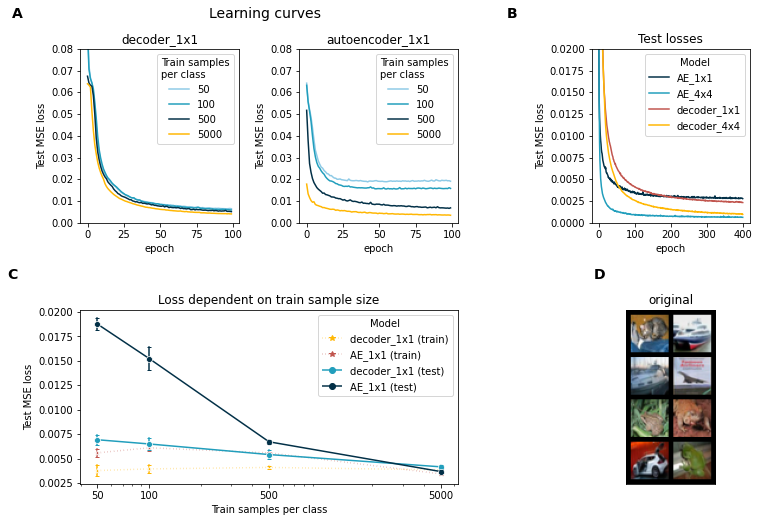

In [14]:
total_rows = 2
total_columns = 10

fig = plt.figure(figsize=(12,8))

anno_opts = dict(xycoords='axes fraction',
                 va='center', ha='center',fontsize=14)

###
# first row in plot
###
ax3a = plt.subplot2grid((total_rows,total_columns), (0,0), colspan=3)
sns.lineplot(data=data3[data3['model']=='decoder'], x='epoch', y='loss', 
             hue='train_samples_per_class', ax=ax3a, palette=sns.color_palette(my_colors[0:4]))
ax3a.set_ylim((0,0.08))
ax3a.set_ylabel('Test MSE loss')
ax3a.set_title('decoder_1x1')
#ax3a.get_legend().remove()
ax3a.legend(title='Train samples\nper class')
ax3a.annotate('A', xy=(-0.4, 1.2), weight='bold', **anno_opts)
ax3a.annotate('Learning curves', xy=(1.17, 1.2), **anno_opts)

ax3b = plt.subplot2grid((total_rows,total_columns), (0,3), colspan=3)
sns.lineplot(data=data3[data3['model']=='AE'], x='epoch', y='loss', 
             hue='train_samples_per_class', ax=ax3b, palette=sns.color_palette(my_colors[0:4]))
ax3b.set_ylim((0,0.08))
ax3b.set_ylabel('Test MSE loss')
ax3b.set_title('autoencoder_1x1')
ax3b.legend(title='Train samples\nper class')
#ax3b.annotate('B', xy=(-0.3, 1.1), **anno_opts)

ax4 = plt.subplot2grid((total_rows,total_columns), (0,7), colspan=3)
sns.lineplot(data=history_test, x='epoch', y='loss', hue='model',
             palette=sns.color_palette(['#023047', '#219ebc', '#C1554E', '#ffb703']),
             ax=ax4)
ax4.set_title('Test losses')
ax4.set_ylabel('Test MSE loss')
ax4.set_ylim((0,0.02))
ax4.legend(title='Model')
ax4.annotate('B', xy=(-0.5, 1.2), weight='bold', **anno_opts)

###
# second row
###
ax1 = plt.subplot2grid((total_rows,total_columns), (1,0), colspan=6)
sns.lineplot(data=data2[data2['type']=='train'], x='train_samples_per_class',
             y='loss', hue='model', style='model', palette=sns.color_palette(['#ffb703', '#C1554E']),
             ci="sd", err_style="bars", markers=['*','*'], dashes=[(0.2,2),(0.2,2)],
             err_kws={'capsize':2}, hue_order=['decoder','AE'], estimator='mean',
             ax=ax1)
sns.lineplot(data=data2[data2['type']=='test'], x='train_samples_per_class',
             y='loss', hue='model', style='model', palette=sns.color_palette(['#219ebc', '#023047']),
             ci="sd", err_style="bars", markers=['o','o'], dashes=[(1,0),(1,0)],
             err_kws={'capsize':2}, hue_order=['decoder','AE'], estimator='mean',
             ax=ax1)
ax1.set_xscale('log')
#ax1.set_xticks([50, 100, 500, 5000],[50, 100, 500, 5000])
ax1.set_xticks([50, 100, 500, 5000])
ax1.set_xticklabels([50, 100, 500, 5000])
ax1.set_xlabel('Train samples per class')
ax1.set_ylabel('Test MSE loss')
ax1.set_title('Loss dependent on train sample size')
L=ax1.legend(title='Model')
L.get_texts()[0].set_text('decoder_1x1 (train)')
L.get_texts()[1].set_text('AE_1x1 (train)')
L.get_texts()[2].set_text('decoder_1x1 (test)')
L.get_texts()[3].set_text('AE_1x1 (test)')
ax1.annotate('C', xy=(-0.18, 1.2), weight='bold', **anno_opts)
#ax1.annotate('Learning curves', xy=(0.5, 1.2), **anno_opts)

ax2 = plt.subplot2grid((total_rows,total_columns), (1,7), colspan=3)
images_test_list = []
for j in range(8):
    images_test_list.append(testset.data[j][0])
ax2.set_title('original')
show_image(torchvision.utils.make_grid(images_test_list,2,4),a=ax2)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.annotate('D', xy=(-0.3, 1.2), weight='bold', **anno_opts)


###
# third row
###
#ax5 = plt.subplot2grid((total_rows,total_columns), (2,0), colspan=6)

#plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=5, hspace=0.5)
plt.show()

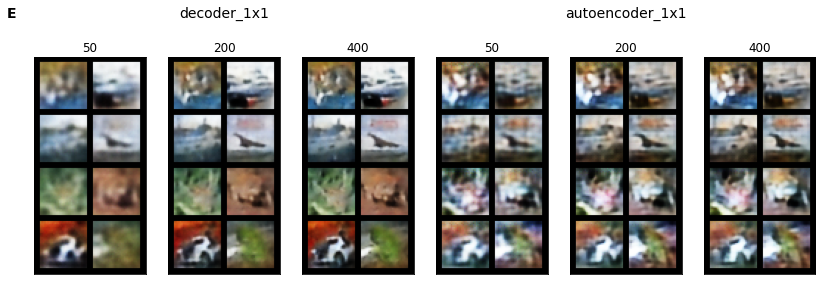

In [15]:
rep_recon_plot_mixed(testset, decoder_list, test_rep_list, ae_list, stops, annot_labels=['decoder_1x1','autoencoder_1x1','E'])

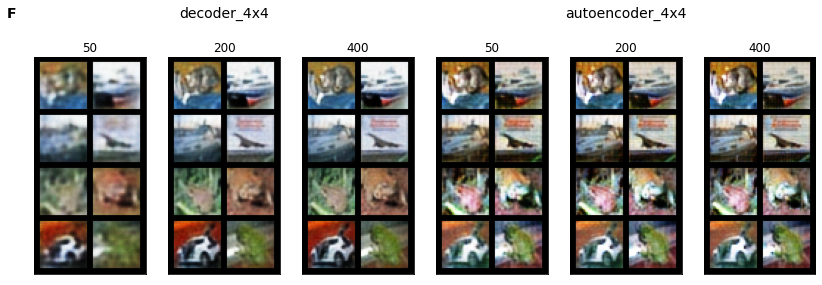

In [16]:
rep_recon_plot_mixed(testset, decoder2_list, test_rep2_list, ae2_list, stops, annot_labels=['decoder_4x4','autoencoder_4x4','F'])